In [221]:
import numpy as np

# 3-state qudit

In [222]:
d = 3

### Generate "unkown" state you want to learn

In [223]:
# From ChatGPT
def random_complex_vector(n):
    # Generate random real and imaginary parts
    real_part = np.random.randn(n)
    imag_part = np.random.randn(n)
    
    # Combine them to form a complex vector
    vector = real_part + 1j * imag_part
    
    # Normalize the vector to have norm = 1
    norm = np.linalg.norm(vector)
    normalized_vector = vector / norm
    
    return normalized_vector

In [224]:
psi = random_complex_vector(d).reshape(-1, 1)
unkown_dm = psi @ psi.conj().T

### Define measurement bases 

In [225]:
# TODO: figure out if these are the right bases
measurement_strings = ["0", "1", "2", "+", "+-+", "-+-" "_i_", "i_i", "_-i_", "-i_-i"]

zero = np.array([1, 0, 0]).reshape(-1, 1)
one = np.array([0, 1, 0]).reshape(-1, 1)
two = np.array([0, 0, 1]).reshape(-1, 1)

# -1 phase
plus = 1/np.sqrt(3) * np.array([1, 1, 1]).reshape(-1, 1)
minus = 1/np.sqrt(3) * np.array([1, -1, 1]).reshape(-1, 1)
minus_minus = 1/np.sqrt(3) * np.array([-1, 1, -1]).reshape(-1, 1)

# i phase
_i_ = 1/np.sqrt(3) * np.array([1, 1j, 1]).reshape(-1, 1)
i_i = 1/np.sqrt(3) * np.array([1j, 1, 1j]).reshape(-1, 1)

# -i phase
_minusi_ = 1/np.sqrt(3) * np.array([1, -1j, 1]).reshape(-1, 1)
minusi_minusi = 1/np.sqrt(3) * np.array([-1j, 1, -1j]).reshape(-1, 1)

basis_states = [zero, one, two, plus, minus, minus_minus, _i_, i_i, _minusi_, minusi_minusi]

### Create measurement projectors

In [226]:
measurement_operators = [state_vector @ state_vector.conj().T for state_vector in basis_states]
measurement_op_dict = dict(zip(measurement_strings, measurement_operators))
#measurement_op_dict

### Compute probabilities to use as the data to fit to
Experimentally, you would compute these from measurement counts

In [227]:
def get_probabilities(dm):
    return [np.trace(dm @ measurement_op).real for measurement_op in measurement_operators]

probabilities = get_probabilities(unkown_dm)
prob_dict = dict(zip(measurement_strings, probabilities))

### Create tunable state
Parameterization from Kwiat group lecture: https://www.youtube.com/watch?v=-T_GiHE4VGg

In [228]:
def get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    T = np.array([[t1, 0, 0],
                  [t4 + 1j*t5, t2, 0],
                  [t8 + 1j*t9, t6 + 1j*t7, t3]])
    
    parameterized_rho = (T.conj().T @ T) / np.trace(T.conj().T @ T)
    
    return parameterized_rho

In [229]:
dm_parameters = np.random.uniform(low=-1, high=1, size=9)

In [230]:
parameterized_dm = get_parameterized_dm(*dm_parameters)

### Test that DM is valid

In [231]:
# Check that trace is close to one
assert np.allclose(1, np.trace(parameterized_dm))

# Check Hermitian
assert np.allclose(parameterized_dm, parameterized_dm.conj().T)

# Check positive-semi definite <--> eigenvalues >= 0
assert np.all(np.linalg.eigvalsh(parameterized_dm) >= 0)

### Optimize with SciPy

In [232]:
def get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9):
    parameterized_dm = get_parameterized_dm(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    probabilities = get_probabilities(parameterized_dm)
    return probabilities

In [233]:
from scipy.special import kl_div

def kl_divergence(true_probs, t1, t2, t3, t4, t5, t6, t7, t8, t9):
    probs = get_probabilites_from_parameters(t1, t2, t3, t4, t5, t6, t7, t8, t9)
    return sum(kl_div(true_probs, probs))

kl_divergence_from_parameters = lambda params : kl_divergence(probabilities, *params)

In [234]:
from scipy.optimize import minimize

# TODO: try different methods
#optimization_result = minimize(kl_divergence_from_parameters, dm_parameters, method="L-BFGS-B")
optimization_result = minimize(kl_divergence_from_parameters, dm_parameters)


In [235]:
found_params = optimization_result.x

found_dm = get_parameterized_dm(*found_params)

In [236]:
dm_fidelity = lambda d1, d2 : np.trace(d1.T.conj() @ d2).real

dm_fidelity(unkown_dm, found_dm)

0.9911850116102388

### Plot Density Matrices

In [237]:
import matplotlib as mplt
import matplotlib.pyplot as plt
%matplotlib inline

In [238]:
def bar_plot_3d(top, title=""):
    # set up the figure and axes
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(121, projection='3d')

    x_dim = y_dim = len(top)
    
    # fake data
    _x = np.arange(x_dim)
    _y = np.arange(y_dim)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    # top = x + y

    bottom = np.zeros_like(top)
    width = depth = 0.5

    ax.bar3d(x, y, bottom.flatten(), width, depth, top.flatten(), shade=True)
    ax.set_title(title)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xlabel("row")
    ax.set_ylabel("column")


    plt.show()

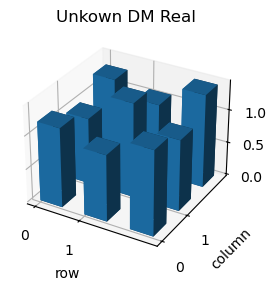

[[1.18902142 0.99507325 1.26989127]
 [0.99507325 1.41262269 1.06618241]
 [1.26989127 1.06618241 1.39835589]]


In [239]:
bar_plot_3d(unkown_dm.real + 1, title="Unkown DM Real")
print(unkown_dm.real + 1)

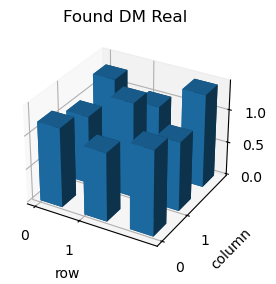

[[1.18901624 1.02579839 1.26988017]
 [1.02579839 1.41264466 1.035447  ]
 [1.26988017 1.035447   1.39833909]]


In [240]:
bar_plot_3d(found_dm.real + 1, title="Found DM Real")
print(found_dm.real + 1)

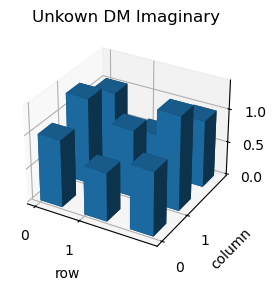

[[1.         0.72076846 0.95043691]
 [1.27923154 1.         1.39998821]
 [1.04956309 0.60001179 1.        ]]


In [241]:
bar_plot_3d(unkown_dm.imag + 1, title="Unkown DM Imaginary")
print(unkown_dm.imag + 1)

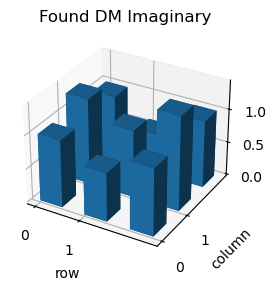

[[1.         0.72329721 1.00118531]
 [1.27670279 1.         1.40249247]
 [0.99881469 0.59750753 1.        ]]


In [242]:
bar_plot_3d(found_dm.imag + 1, title="Found DM Imaginary")
print(found_dm.imag + 1)